In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [1]:

def get_stars_in_master_files():
    ''' A short function to read in the old star master files, 
    and check how many different stars are in 
    1) beginning 18 master files that had been used before alongside QSO
    2) all 128 master files . 
    This allows to check whether using only 18 random files out of 128 
    did not introduce any selection effects towards the available stars 
    
    Returns:
    -------
    a : list of names of stars present in the 128 master files 
    b : list of names of stars present in the first 18 master files, the
        same 18 files that were used in the analysis prior to making 
        one master per lightcurve 
        
    '''
    inDirStars   = 'sf_TRY/sf_stars/'
    inDirQSO = 'sf_TRY/sf_qso/'
    
    S = os.listdir(inDirStars)
    Q = os.listdir(inDirQSO)
    
    # Find out what stars are available for analysis in all 128 stellar master files 
    
    star_names = [] 
    
    for i in range(len(S)):
        print 'Processing ', S[i],'-', i, 'out of ', len(S)
        master = np.genfromtxt(inDirStars+S[i], dtype=str)
        names = master[:,3]
        uniq_names = np.unique(names)
        star_names.append(uniq_names)
    
    a = []
    extend = a.extend
    for s in star_names:
        extend(s)
    np.savetxt('Master_files_stars_128_names.txt', a, fmt='%s', delimiter=' ' )
    
    # Find out what stars were available for analysis in 18 master files...
    star_names_choice = []
    for i in range(len(Q)):
        print 'Processing ', S[i]
        master = np.genfromtxt(inDirStars+S[i], dtype=str)
        names = master[:,3]
        uniq_names = np.unique(names)
        star_names_choice.append(uniq_names)
    
    b = []
    extend = b.extend
    for s in star_names_choice:
        extend(s)
        
    np.savetxt('Master_files_stars_18_names.txt', b, fmt='%s', delimiter=' ')
    
    return a,b 

# read in the result of calculations 
a = np.genfromtxt('Master_files_stars_128_names.txt', dtype='str')
b = np.genfromtxt('Master_files_stars_18_names.txt', dtype='str')
# grab info about those stars from a catalog 
    
def get_stars_catalog():
    File = 'CRTS_SDSS_cross_matched_stars_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File)
    stars_catalog = {}
    print 'zipping CRTS-SDSS stars catalog...'
    for label, column in zip(colnames, datatable.T):
        stars_catalog[label] = column
        
    return  colnames, stars_catalog

cols2 , star_cat= get_stars_catalog()

zipping CRTS-SDSS stars catalog...


In [24]:
# See what's available in the catalog... 
cols2

['CRTS_M',
 'CRTS_Merr',
 'dec_SDSS',
 'ra_SDSS',
 'dec_CRTS',
 'ra_CRTS',
 'g_Nobs',
 'g_mMed',
 'r_mMed',
 'i_mMed',
 'crts_id',
 'mjd_span',
 'mjd_N',
 'N_rows']

In [17]:
# All the names of stars in all 128 master files are in the cross-matched  catalog
print np.sum(np.in1d(a.astype(float),star_cat['crts_id'])) == len(a)

True


In [22]:
# Select rows corresponding to two samples : a is all 128 master files, 
# b is the 18 master files actually used 
ma = np.in1d(star_cat['crts_id'],a.astype(float))
mb = np.in1d(star_cat['crts_id'],b.astype(float))

# Before the cut : what is available?

Plot from what stars are we making selection - i.e. what is the pool of stars in those two cases on which we are imposing further cuts ? 

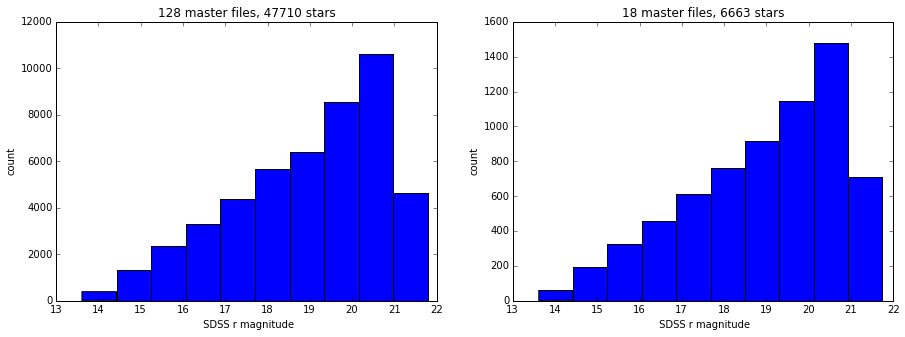

In [45]:
# 47710 Stars in all 128 files
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(star_cat['r_mMed'][ma])
ax[0].set(title='128 master files, 47710 stars' , xlabel=' SDSS r magnitude ', 
             ylabel='count'  )

ax[1].hist(star_cat['r_mMed'][mb])
ax[1].set(title='18 master files, 6663 stars' , xlabel=' SDSS r magnitude ', 
             ylabel='count'  )

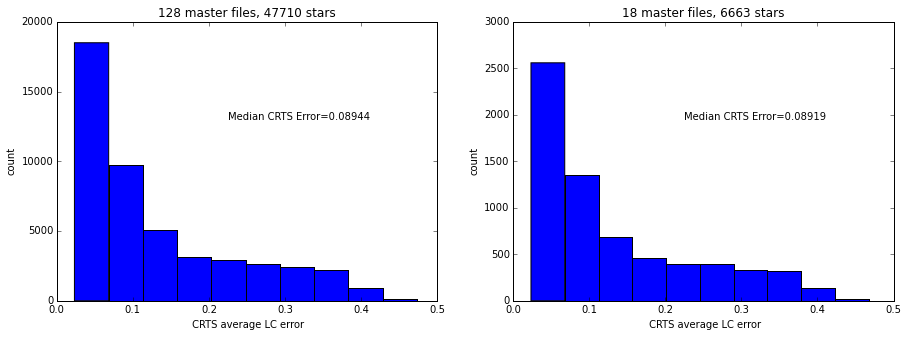

In [57]:
# 6663 Stars in the 18 files 
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
da=star_cat['CRTS_Merr'][ma]
ax[0].hist(da)
ax[0].set(title='128 master files, 47710 stars' , xlabel=' CRTS average LC error ', ylabel='count'  )
ax[0].text(0.45, 0.65, 'Median CRTS Error=%.5f'%np.median(da) ,transform=ax[0].transAxes)
db=star_cat['CRTS_Merr'][mb]
ax[1].hist(db)
ax[1].set(title='18 master files, 6663 stars' , xlabel=' CRTS average LC error ', ylabel='count'  )
ax[1].text(0.45, 0.65, 'Median CRTS Error=%.5f'%np.median(db) ,transform=ax[1].transAxes)

# After the cut : what blue stars do we have ? 

So from the above plots the distribution of properties that I can choose from seems very similar, since for star selection I use SDSS r magnitude and the CRTS average lightcurve error. Verify that : make   17-19 mag, and <0.3 err cut,  and 0-20, < 0.3 err cut, and compare the distributions after the cut - i.e. from available stars, what are the ones that we select?  


In [66]:
def cut_stars(star_cat=star_cat, mMin=-9, mMax=19, mErrMin = -9, 
              mErrMax = 0.3, gi_Min = -1, gi_Max=1  ):

    mask_mag = (star_cat['r_mMed'] > mMin) * (star_cat['r_mMed'] < mMax) 
    mask_err = (star_cat['CRTS_Merr'] > mErrMin) * (star_cat['CRTS_Merr'] < mErrMax)
    SDSS_gi = star_cat['g_mMed'] - star_cat['i_mMed']
    mask_color = (SDSS_gi > gi_Min ) * (SDSS_gi < gi_Max)
    mask = mask_mag * mask_err * mask_color
    star_id = star_cat['crts_id'][mask]
   
    print '\n These cuts reduced the number of stars  in the sample from', \
          len(star_cat['CRTS_M']), ' to ', len(star_id)
    return  star_id

In [67]:
id_1 = cut_stars(mMin=17, mMax=19)
id_2 = cut_stars(mMin=0, mMax=20)


 These cuts reduced the number of stars  in the sample from 47787  to  5698

 These cuts reduced the number of stars  in the sample from 47787  to  13845


In [73]:
# Mask which stars from my samples are in the either cut 

ma1 = np.in1d(a.astype(float), id_1)
ma2 = np.in1d(a.astype(float), id_2)

mb1 = np.in1d(b.astype(float), id_1)
mb2 = np.in1d(b.astype(float), id_2)

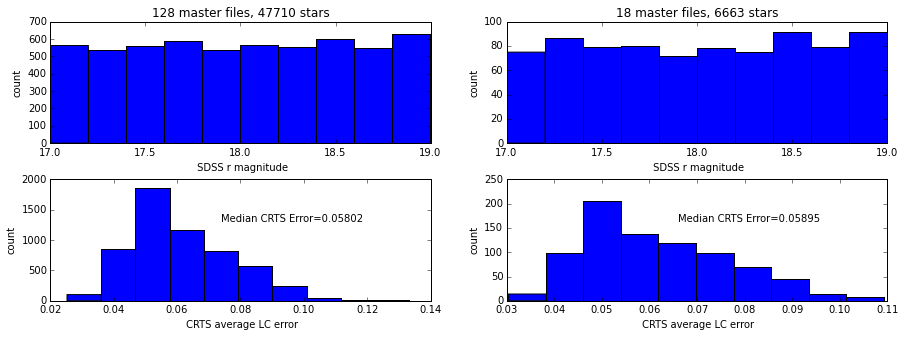

In [79]:
# Compare stars from different samples but identical cuts : do I get the same distributions of mag, err ? 

#  17-19  mag cut 

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
mska = np.in1d(star_cat['crts_id'],a.astype(float)[ma1] )
mskb = np.in1d(star_cat['crts_id'],b.astype(float)[mb1] )

ax[0,0].hist(star_cat['r_mMed'][mska])
ax[0,0].set(title='128 master files, 47710 stars' , xlabel=' SDSS r magnitude ', 
             ylabel='count'  )

ax[0,1].hist(star_cat['r_mMed'][mskb])
ax[0,1].set(title='18 master files, 6663 stars' , xlabel=' SDSS r magnitude ', 
             ylabel='count'  )

da=star_cat['CRTS_Merr'][mska]
ax[1,0].hist(da)
ax[1,0].set( xlabel=' CRTS average LC error ', ylabel='count'  )
ax[1,0].text(0.45, 0.65, 'Median CRTS Error=%.5f'%np.median(da) ,transform=ax[1,0].transAxes)

db=star_cat['CRTS_Merr'][mskb]
ax[1,1].hist(db)
ax[1,1].set( xlabel=' CRTS average LC error ', ylabel='count'  )
ax[1,1].text(0.45, 0.65, 'Median CRTS Error=%.5f'%np.median(db) ,transform=ax[1,1].transAxes)

fig.subplots_adjust(hspace=0.3)

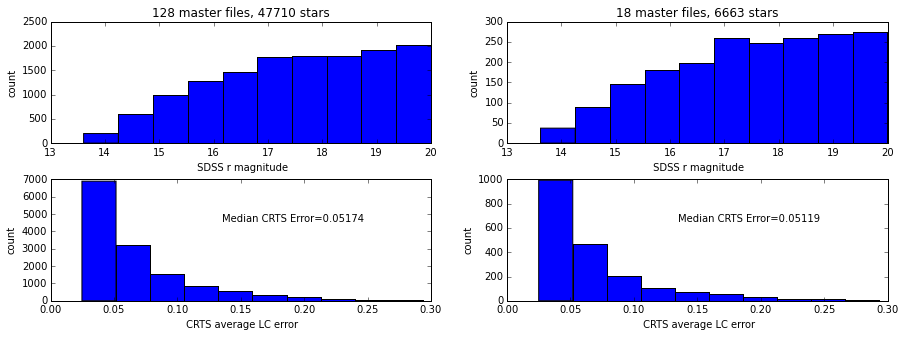

In [80]:
# Compare stars from different samples but identical cuts : do I get the same distributions of mag, err ? 

# 0-20  mag cut 

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
mska = np.in1d(star_cat['crts_id'],a.astype(float)[ma2] )
mskb = np.in1d(star_cat['crts_id'],b.astype(float)[mb2] )

ax[0,0].hist(star_cat['r_mMed'][mska])
ax[0,0].set(title='128 master files, 47710 stars' , xlabel=' SDSS r magnitude ', 
             ylabel='count'  )

ax[0,1].hist(star_cat['r_mMed'][mskb])
ax[0,1].set(title='18 master files, 6663 stars' , xlabel=' SDSS r magnitude ', 
             ylabel='count'  )

da=star_cat['CRTS_Merr'][mska]
ax[1,0].hist(da)
ax[1,0].set( xlabel=' CRTS average LC error ', ylabel='count'  )
ax[1,0].text(0.45, 0.65, 'Median CRTS Error=%.5f'%np.median(da) ,transform=ax[1,0].transAxes)

db=star_cat['CRTS_Merr'][mskb]
ax[1,1].hist(db)
ax[1,1].set( xlabel=' CRTS average LC error ', ylabel='count'  )
ax[1,1].text(0.45, 0.65, 'Median CRTS Error=%.5f'%np.median(db) ,transform=ax[1,1].transAxes)

fig.subplots_adjust(hspace=0.3)